### Redes Neurais e Arquiteturas Profundas
#### **MBA em Ciências de Dados**

## *Módulo 3 - Redes Neurais Convolucionais (CNNs)*

### **MLP vs CNN**

Moacir A. Ponti

## Exemplo de uso de redes neurais profundas para classificação de imagens

### 1. Como tratar bases de imagens antes de começar a processar
### 2. Comparação: Rede Densa (MLP) vs Rede Convolucional (CNN)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
# testando o uso de GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [68]:
# Carregando dataset a partir de TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('fashion_mnist', 
                                         split=['train[:15%]', 'test[:30%]'], 
                                         as_supervised=True, with_info=True)
num_classes = ds_info.features['label'].num_classes

2023-10-02 19:40:05.266735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


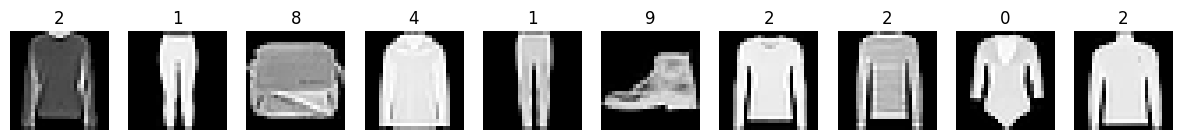

In [69]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{label}")
    plt.show()

# extrai primeiras 10 imagens para exibir
list_images = []
list_labels = []
for example in ds_train.take(10):
    image = example[0].numpy()
    label = example[1].numpy()
    list_images.append(image)
    list_labels.append(label)
    
show_images(list_images, list_labels)

In [70]:
# Resolucao da imagem
image_resolution = ds_info.features['image'].shape

# Tamanho do dataset
num_train_examples_total = ds_info.splits['train'].num_examples
num_test_examples_total = ds_info.splits['test'].num_examples
# TAmanho do dataset realmente carregado
num_train_examples = tf.data.experimental.cardinality(ds_train).numpy()
num_test_examples = tf.data.experimental.cardinality(ds_test).numpy()

# Número de classes
num_classes = ds_info.features['label'].num_classes

print(f"Resolução: {image_resolution}")
print(f"Training Set: {num_train_examples} exemplos de {num_train_examples_total} totais")
print(f"Testing Set: {num_test_examples} exemplos de {num_test_examples_total} totais")
print(f"Classes: {num_classes}")

Resolução: (28, 28, 1)
Training Set: 9000 exemplos de 60000 totais
Testing Set: 3000 exemplos de 10000 totais
Classes: 10


---

Sabendo as características do dataset, agora, o passo ideal é **pré-processar** as imagens para facilitar o processo de otimização das redes neurais:

1. Normalizar seus valores (para o intervalo 0-1)
2. Alterar a codificação das classes (para one-hot-encoding): teremos 10 neurônios na saída, não apenas 1

In [71]:
# Exibindo dados originais
for image, label in ds_train.take(1):
    print(image.numpy()[16,:10])
    print(label.numpy())

[[  0]
 [  0]
 [  0]
 [  0]
 [ 83]
 [ 71]
 [136]
 [194]
 [126]
 [ 46]]
2


2023-10-02 19:41:59.390116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [72]:
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label
    
# Pre-processa imagens
def preprocess_image(image, label):
    # converte imagem para float32
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

ds_train = ds_train.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

ds_train = ds_train.map(one_hot_label)
ds_test = ds_test.map(one_hot_label)

In [73]:
# Exibindo dados processados
for image, label in ds_train.take(1):
    print(image.numpy()[16,:10])
    print(label.numpy())

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.3254902 ]
 [0.2784314 ]
 [0.53333336]
 [0.7607844 ]
 [0.49411768]
 [0.18039216]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


2023-10-02 19:43:04.334009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Tudo pronto, agora vamos começar

OBS: poderíamos ter feito mais etapas de pré-processamento aqui, como por exemplo normalização z-score das imagens, remoção de outliers, etc.

### Vamos aos concorrentes
1. Multilayer Perceptron, com (pelo menos) 60 anos de vida, uma densa experiência e muitas conexões

2. Rede convolucional, mais jovem porém com menos graus de liberdade e maior quantidade de representações intermediárias por camada.

In [59]:
# concorrente número um, no canto direito!
MLP = keras.Sequential()

MLP.add(keras.layers.InputLayer(input_shape=image_resolution)) 
# precisamos achatar a imagem para um vetor antes de começar
MLP.add(keras.layers.Flatten()) 
MLP.add(keras.layers.Dense(256, activation="relu"))
MLP.add(keras.layers.Dense(256, activation="relu"))
MLP.add(keras.layers.Dense(256, activation="relu"))
MLP.add(keras.layers.Dense(256, activation="relu"))
MLP.add(keras.layers.Dense(10, activation='softmax'))
MLP.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               200960    
                                                                 
 dense_44 (Dense)            (None, 256)               65792     
                                                                 
 dense_45 (Dense)            (None, 256)               65792     
                                                                 
 dense_46 (Dense)            (None, 256)               65792     
                                                                 
 dense_47 (Dense)            (None, 10)                2570      
                                                                 
Total params: 400906 (1.53 MB)
Trainable params: 4009

In [60]:
# o concorrente novato, no canto esquerdo!
CNN = keras.Sequential()

CNN.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), 
                            padding='valid', activation='relu', 
                            input_shape=image_resolution))
CNN.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), 
                            padding='valid', activation='relu', 
                            input_shape=image_resolution))
CNN.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                            padding='same', activation='relu'))

CNN.add(keras.layers.Flatten())
CNN.add(keras.layers.Dense(128, activation="relu"))
CNN.add(keras.layers.Dense(10, activation='softmax'))
CNN.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 13, 13, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 conv2d_34 (Conv2D)          (None, 6, 6, 64)          36928     
                                                                 
 flatten_20 (Flatten)        (None, 2304)              0         
                                                                 
 dense_48 (Dense)            (None, 128)               295040    
                                                                 
 dense_49 (Dense)            (None, 10)                1290      
                                                                 
Total params: 352074 (1.34 MB)
Trainable params: 3520

### 1) Preparando o dataset e os modelos

In [48]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
from tensorflow.random import set_seed

seed(1)
set_seed(2)

# vamos usar o mesmo número de épocas e batchsize para ambos
batch_size = 64
epochs = 25

# definindo o batch size para iterar sobre o dataset
ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)

In [61]:
# compilando os modelos
MLP.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1),
              metrics=['accuracy'])

CNN.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1),
              metrics=['accuracy'])

## **E lá vamos nós**: em quem você apostaria?

In [62]:
histMLP = MLP.fit(ds_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=0)

scoreMLP_Tr = MLP.evaluate(ds_train, verbose = 0)
scoreMLP_Te = MLP.evaluate(ds_test, verbose = 0)

In [63]:
histCNN = CNN.fit(ds_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    verbose=0)

scoreCNN_Tr = CNN.evaluate(ds_train, verbose = 0)
scoreCNN_Te = CNN.evaluate(ds_test, verbose = 0)

Text(0.5, 1.0, 'Perda ao longo das épocas')

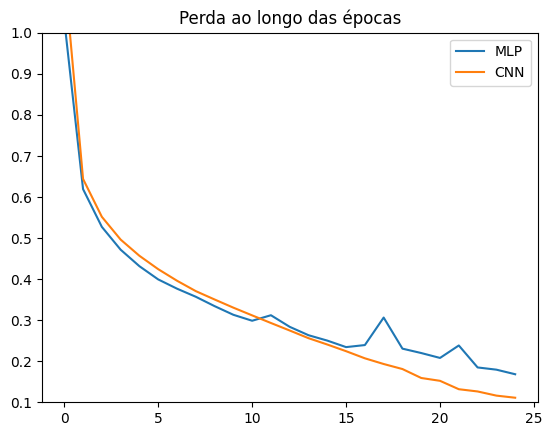

In [64]:
plt.plot(histMLP.history['loss'])
plt.plot(histCNN.history['loss'])
plt.ylim([0.1,1.0])
plt.legend(["MLP", "CNN"], loc="upper right")
plt.title("Perda ao longo das épocas")

In [23]:
print(f"MLP Acurácia treinamento: {(scoreMLP_Tr[1]*100):.2f}%")
print(f"MLP Acurácia teste: {(scoreMLP_Te[1]*100):.2f}%\n")

print(f"CNN Acurácia treinamento: {(scoreCNN_Tr[1]*100):.2f}%")
print(f"CNN Acurácia teste: {(scoreCNN_Te[1]*100):.2f}%")

MLP Acurácia treinamento: 86.69%
MLP Acurácia teste: 82.27%

CNN Acurácia treinamento: 92.09%
CNN Acurácia teste: 84.43%
